In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os

In [23]:
def initialize_c_corner_deleted(num_grid_, num_side_, scale_factor_):
    c = np.zeros((num_grid_+2, num_grid_+2, num_side_))
        
    # setting side value
    for i in range(num_grid_-2):
        c[0+1, 0+1+1+i, 1] = 0.375/scale_factor_ # right side of upper side
        c[0+1, 0+1+1+i, 3] = 0.375/scale_factor_ # left side of upper side
        c[0+1, 0+1+1+i, 2] = 0.25/scale_factor_ # down side of upper side
    for i in range(num_grid_-2):
        c[num_grid_, 0+1+1+i, 1] = 0.375/scale_factor_ # right side of bottom side
        c[num_grid_, 0+1+1+i, 3] = 0.375/scale_factor_ # left side of bottom side
        c[num_grid_, 0+1+1+i, 0] = 0.25/scale_factor_ # upper side of bottom side
    for i in range(num_grid_-2):
        c[0+1+1+i, num_grid_, 0] = 0.375/scale_factor_ # upper side of right side
        c[0+1+1+i, num_grid_, 2] = 0.375/scale_factor_ # bottom side of right side
        c[0+1+1+i, num_grid_, 3] = 0.25/scale_factor_ # left side of right side
    for i in range(num_grid_-2):
        c[0+1+1+i, 0+1, 0] = 0.375/scale_factor_ # upper side of left side
        c[0+1+1+i, 0+1, 2] = 0.375/scale_factor_ # bottom side of left side
        c[0+1+1+i, 0+1, 1] = 0.25/scale_factor_ # right side of left side
    
    # connecting corner
    c[1, 1, 1] = c[1, 1, 2] = 0.375/scale_factor_ # upper left
    c[1, num_grid_, 2] = c[1, num_grid_, 3] = 0.375/scale_factor_ # upper right
    c[num_grid_, 1, 0] = c[num_grid_, 1, 1] = 0.375/scale_factor_ # bottom left
    c[num_grid_, num_grid_, 0] = c[num_grid_, num_grid_, 3] = 0.375/scale_factor_ # bottom right
    
    # setting most of the grid
    for i in range(num_grid_-2):
        for j in range(num_grid_-2):
            for k in range(4):
                c[i+2, j+2, k] = 0.25/scale_factor_
    
    #print(c)
    return c
    
c = initialize_c_corner_deleted(9, 4, 100)
print(c)

[[[ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.       0.00375  0.00375  0.     ]
  [ 0.       0.00375  0.0025   0.00375]
  [ 0.       0.00375  0.0025   0.00375]
  [ 0.       0.00375  0.0025   0.00375]
  [ 0.       0.00375  0.0025   0.00375]
  [ 0.       0.00375  0.0025   0.00375]
  [ 0.       0.00375  0.0025   0.00375]
  [ 0.       0.00375  0.0025   0.00375]
  [ 0.       0.       0.00375  0.00375]
  [ 0.       0.       0.       0.     ]]

 [[ 0.       0.       0.       0.     ]
  [ 0.00375  0.0025   0.00375  0.     ]
  [ 0.0025   0.0025   0.0025   0.002

In [3]:
def gain_function_(z, alpha):
    return alpha * math.log(1 + math.exp(z/alpha))

def single_population_rate_model_(E_t, u_t, x_t, z_t, J, alpha, tau, E_0_default, Ext_input, t_fac, t_d, t_th, thre_effi, U, dt):
    du = (U - u_t) / t_fac + U * (1 - u_t) * E_t    
    dE = (- E_t + gain_function_((J * u_t * x_t * E_t + E_0_default + Ext_input - thre_effi * z_t), alpha)) / tau
    dx = (1 - x_t) / t_d - u_t * x_t * E_t
    dz = (E_t - z_t)/t_th
    
    E_t_ = E_t + dE * dt
    x_t_ = x_t + dx * dt
    u_t_ = u_t + du * dt
    z_t_ = z_t + dz * dt
    return E_t_, u_t_, x_t_, z_t_

def init_dynamical_variable_and_time(num_grid, T, E_ini, u_ini, x_ini, z_ini):
    time = np.zeros(int(T))
    E_t = np.zeros((int(T), num_grid + 2, num_grid + 2))
    u_t = np.zeros((int(T), num_grid + 2, num_grid + 2))
    x_t = np.zeros((int(T), num_grid + 2, num_grid + 2))
    z_t = np.zeros((int(T), num_grid + 2, num_grid + 2))
    
    # E_t[time_index, grid_index_i, grid_index_j]
    E_t[0, :, :] = E_ini
    # E_t[:, 0, :] and E_t[:, num_grid + 1, :] and E_t[:, :, 0] and E_t[:, :, num_grid + 1] is boundary. 
    # this value has no physical meaning.
    if E_ini != 0:
        E_t[:, 0, :] = E_t[:, num_grid + 1, :] = E_t[:, :, 0] = E_t[:, :, num_grid + 1] = 0
    
    u_t[0, :, :] = u_ini
    if u_ini != 0:
        u_t[:, 0, :] = u_t[:, num_grid + 1, :] = u_t[:, :, 0] = u_t[:, :, num_grid + 1] = 0
    x_t[0, :, :] = x_ini
    if x_ini != 0:
        x_t[:, 0, :] = x_t[:, num_grid + 1, :] = x_t[:, :, 0] = x_t[:, :, num_grid + 1] = 0
    z_t[0, :, :] = z_ini
    #print(E_t, u_t, x_t, z_t)
    return time, E_t, u_t, x_t, z_t

In [18]:
def start_simulation(T, num_grid, time, E_t, u_t, x_t, z_t, J, alpha, tau, E_0_default, t_fac, t_d, t_th, thre_effi, U, dt):
    print("starting sinulation\ngrid size {}*{} simulation time {}sec".format(num_grid, num_grid, int(T*dt)))
    print("parameters are following\ntau {} t_fac {} t_d {} t_th {} U {}".format(tau, t_fac, t_d, t_th, U))
    print("J {} alpha {} thre_effi {}".format(J, alpha, thre_effi))
    for i in range(int(T) - 1):
        time[i+1] = i * dt
        for grid_index_i in range(num_grid):
            for grid_index_j in range(num_grid):
                E_t[i+1, grid_index_i+1, grid_index_j+1], u_t[i+1, grid_index_i+1, grid_index_j+1], x_t[i+1, grid_index_i+1, grid_index_j+1]\
                , z_t[i+1, grid_index_i+1, grid_index_j+1] \
                = single_population_rate_model_(E_t[i, grid_index_i+1, grid_index_j+1], u_t[i, grid_index_i+1, grid_index_j+1]\
                                        , x_t[i, grid_index_i+1, grid_index_j+1], z_t[i, grid_index_i+1, grid_index_j+1]\
                                        , J, alpha, tau, E_0_default\
                                        , c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[i, grid_index_i+1-1, grid_index_j+1] * u_t[i, grid_index_i+1-1, grid_index_j+1] * x_t[i, grid_index_i+1-1, grid_index_j+1]\
                                        + c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[i, grid_index_i+1, grid_index_j+1+1] * u_t[i, grid_index_i+1, grid_index_j+1+1] * x_t[i, grid_index_i+1, grid_index_j+1+1]\
                                        + c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[i, grid_index_i+1+1, grid_index_j+1] * u_t[i, grid_index_i+1+1, grid_index_j+1] * x_t[i, grid_index_i+1+1, grid_index_j+1]\
                                        + c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[i, grid_index_i+1, grid_index_j+1-1] * u_t[i, grid_index_i+1, grid_index_j+1-1] * x_t[i, grid_index_i+1, grid_index_j+1-1]\
                                        , t_fac, t_d, t_th, thre_effi, U, dt)
                print("E_t{}_{}={}=".format(grid_index_i+1, grid_index_j+1, E_t[i, grid_index_i+1,grid_index_j+1]\
                                           ))
        # setting corner value
        E_t[i+1, 1, 1], x_t[i+1, 1, 1], u_t[i+1, 1, 1] = (E_t[i+1, 1, 2] + E_t[i+1, 2, 1])/2, (x_t[i+1, 1, 2] + x_t[i+1, 2, 1])/2, (u_t[i+1, 1, 2] + u_t[i+1, 2, 1])/2 # upper left 
        E_t[i+1, 1, num_grid], x_t[i+1, 1, num_grid], u_t[i+1, 1, num_grid] = (E_t[i+1, 2, num_grid]+E_t[i+1, 1, num_grid-1])/2, (x_t[i+1, 2, num_grid]+x_t[i+1, 1, num_grid-1])/2, (u_t[i+1, 2, num_grid]+u_t[i+1, 1, num_grid-1])/2 # upper right
        E_t[i+1, num_grid, 1], x_t[i+1, num_grid, 1], u_t[i+1, num_grid, 1] = (E_t[i+1, num_grid, 2]+E_t[i+1, num_grid-1, 1])/2, (x_t[i+1, num_grid, 2]+x_t[i+1, num_grid-1, 1])/2, (u_t[i+1, num_grid, 2]+u_t[i+1, num_grid-1, 1])/2 # bottom left
        E_t[i+1, num_grid, num_grid], x_t[i+1, num_grid, num_grid], u_t[i+1, num_grid, num_grid] = (E_t[i+1, num_grid-1, num_grid]+E_t[i+1, num_grid, num_grid-1])/2, (x_t[i+1, num_grid-1, num_grid]+x_t[i+1, num_grid, num_grid-1])/2, (u_t[i+1, num_grid-1, num_grid]+u_t[i+1, num_grid, num_grid-1])/2 # bottom right
        print("after averaging corner grid")
        print(E_t[i+1, :, :])
        key = input("one time step done")
    print("simulation completed !")

def plot_results(plot_dpi):
    plt.clf()
    fig = plt.figure(figsize = (40, 10), dpi = plot_dpi)
    index_grid_i = 1
    for index_grid_j in range(int((num_grid+1)/2)):
        plt.plot(time, E_t[:,index_grid_i,index_grid_j+1], label="E_{}/{}".format(index_grid_j+1, num_grid))
    plt.plot(time, u_t[:,int((num_grid+1)/2), 1], label="u")
    plt.plot(time, x_t[:,int((num_grid+1)/2), 1], label="x")
    #plt.plot(time, z_t[:,1], label="threshold")
    plt.legend(loc="lower right")
    plt.show()

In [7]:
def plot_2d_color_grid(plot_length, start_time, outdir):
    plt.clf()
    
    levels = MaxNLocator(nbins=30).tick_values(E_t.max(), E_t.min())
    cmap = plt.get_cmap('plasma')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    if plot_length == None:
        print("Enter plot length in second order")
        plot_length = input()
    elif start_time == None:
        print("Enter start time of plot in second order")
        start_time = input()
    else:
        for t in range(int(plot_length*(1/dt)/10)):
            plt.clf()
            im = plt.pcolormesh(E_t[t*10+int(start_time*(1/dt)), 1:num_grid+1, 1:num_grid+1], cmap=cmap, norm=norm)
            plt.colorbar(im)
            plt.title("t = {} msec".format(t))
            fname = "/%s/%07d" % (outdir, t)
            plt.savefig('{}.png'.format(os.getcwd() + fname), dpi=100)
            if (t % 1000) == 0:
                print("~{}/{} sec complete".format(int(t*dt*10), int(plot_length)))
    
    print("2d plot finished !!")

In [8]:
def plot_3d_color_surface(plot_length, start_time, outdir):
    plt.clf()
    
    ax = plt.gca(projection = '3d')
    ax.set_zlim(0, E_t.max())
    
    levels = MaxNLocator(nbins=30).tick_values(E_t.max(), E_t.min())
    
    cmap = plt.get_cmap('plasma')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    
    X_=np.arange(1, num_grid+1, 1)
    Y_=np.arange(1, num_grid+1, 1)
    X_, Y_ = np.meshgrid(X_, Y_)
    
    for t in range(int(plot_length*(1/dt)/10)):
        plt.clf()
        ax = plt.gca(projection = '3d')
        ax.set_zlim(0, E_t.max())
        
        surf = ax.plot_surface(X_, Y_, E_t[t*10 + int(start_time*(1/dt)) -1, 1:num_grid+1, 1:num_grid+1], cmap=cm.plasma, norm=norm)
        plt.colorbar(surf)
        plt.title("t = {} msec".format(t))
        fname = "/%s/%07d" % (outdir, t)
        plt.savefig('{}.png'.format(os.getcwd()+fname), dpi = 100)
        if (t % 1000) == 0:
            print("~{}/{} sec completed".format(int(t*dt*10), int(plot_length)))
    
    print("finished !")

In [33]:
# test cell

# test initial value
E_t = np.zeros((int(T), num_grid + 2, num_grid + 2))
E_t[0, :, :] = 1
# boundary
E_t[:, 0, :] = 0
E_t[:, num_grid +1, :] = 0
E_t[:, :, 0] = 0
E_t[:, :, num_grid + 1] = 0
print(E_t[0:2, :, :])

time = 1
grid_index_i = 0
grid_index_j = 1

"""
E_t[time, grid_index_i, grid_index_j] =\
c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[i, grid_index_i+1-1, grid_index_j+1] * u_t[i, grid_index_i+1-1, grid_index_j+1] * x_t[i, grid_index_i+1-1, grid_index_j+1]\
+ c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[i, grid_index_i+1, grid_index_j+1+1] * u_t[i, grid_index_i+1, grid_index_j+1+1] * x_t[i, grid_index_i+1, grid_index_j+1+1]\
+ c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[i, grid_index_i+1+1, grid_index_j+1] * u_t[i, grid_index_i+1+1, grid_index_j+1] * x_t[i, grid_index_i+1+1, grid_index_j+1]\
+ c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[i, grid_index_i+1, grid_index_j+1-1] * u_t[i, grid_index_i+1, grid_index_j+1-1] * x_t[i, grid_index_i+1, grid_index_j+1-1]
"""

E_t[time, grid_index_i+1, grid_index_j+1] =\
c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[time-1, grid_index_i+1-1, grid_index_j+1]
+ c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[time-1, grid_index_i+1, grid_index_j+1+1]
+ c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[time-1, grid_index_i+1+1, grid_index_j+1]
+ c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[time-1, grid_index_i+1, grid_index_j+1-1]

print(E_t[0:2,:,:])

"""
E_t[time, i_index, j_index] = c[i_index-1, j_index, 2] * E_t[time-1, i_index-1, j_index] \
                                               + c[i_index, j_index+1, 3] * E_t[time-1, i_index, j_index+1] \
                                               + c[i_index+1, j_index, 0] * E_t[time-1, i_index+1, j_index] \
                                               + c[i_index, j_index-1, 1] * E_t[time-1, i_index, j_index-1]
"""
print(c)

"""
print("{} = {} + {} + {} + {}".format(E_t[time, grid_index_i, grid_index_j]\
    , c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[i, grid_index_i+1-1, grid_index_j+1] * u_t[i, grid_index_i+1-1, grid_index_j+1] * x_t[i, grid_index_i+1-1, grid_index_j+1]\
    , c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[i, grid_index_i+1, grid_index_j+1+1] * u_t[i, grid_index_i+1, grid_index_j+1+1] * x_t[i, grid_index_i+1, grid_index_j+1+1]\
    , c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[i, grid_index_i+1+1, grid_index_j+1] * u_t[i, grid_index_i+1+1, grid_index_j+1] * x_t[i, grid_index_i+1+1, grid_index_j+1]\
    , c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[i, grid_index_i+1, grid_index_j+1-1] * u_t[i, grid_index_i+1, grid_index_j+1-1] * x_t[i, grid_index_i+1, grid_index_j+1-1]))

"""

print("{} = {} + {} + {} + {}".format(E_t[time, grid_index_i+1, grid_index_j+1]\
                                     , c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[time-1, grid_index_i+1-1, grid_index_j+1]\
                                     , c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[time-1, grid_index_i+1, grid_index_j+1+1]\
                                     , c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[time-1, grid_index_i+1+1, grid_index_j+1]\
                                     , c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[time-1, grid_index_i+1, grid_index_j+1-1]))

[[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.

In [19]:
# general param
E_ini = 0.
u_ini = 1.
x_ini = 0.
z_ini = 0.

dt = 0.0001

In [20]:
# param
T = 10 * (1/dt)
num_grid = 9
num_side = 4
scale_factor=100
c = initialize_c_corner_deleted(num_grid, num_side, scale_factor)

# setting parameter
tau = 0.13
# depressing t_d > t_fac 
# facilitating t_d < t_fac    ++++   prefrontal cortex (PFC) facilitating excitatory connection
t_d = 2
t_fac = 15

t_th = 0.1
thre_effi = 0.02

U = 0.3
E_0_default = -2.3
J = 8
alpha = 0.985

In [21]:
time, E_t, u_t, x_t, z_t = init_dynamical_variable_and_time(num_grid, T, E_ini, u_ini, x_ini, z_ini)

In [22]:
start_simulation(T, num_grid, time, E_t, u_t, x_t, z_t, J, alpha, tau, E_0_default, t_fac, t_d, t_th, thre_effi, U, dt)

starting sinulation
grid size 9*9 simulation time 10sec
parameters are following
tau 0.13 t_fac 15 t_d 2 t_th 0.1 U 0.3
J 8 alpha 0.985 thre_effi 0.02
E_t1_1=0.0
E_t1_2=0.0
E_t1_3=0.0
E_t1_4=0.0
E_t1_5=0.0
E_t1_6=0.0
E_t1_7=0.0
E_t1_8=0.0
E_t1_9=0.0
E_t2_1=0.0
E_t2_2=0.0
E_t2_3=0.0
E_t2_4=0.0
E_t2_5=0.0
E_t2_6=0.0
E_t2_7=0.0
E_t2_8=0.0
E_t2_9=0.0
E_t3_1=0.0
E_t3_2=0.0
E_t3_3=0.0
E_t3_4=0.0
E_t3_5=0.0
E_t3_6=0.0
E_t3_7=0.0
E_t3_8=0.0
E_t3_9=0.0
E_t4_1=0.0
E_t4_2=0.0
E_t4_3=0.0
E_t4_4=0.0
E_t4_5=0.0
E_t4_6=0.0
E_t4_7=0.0
E_t4_8=0.0
E_t4_9=0.0
E_t5_1=0.0
E_t5_2=0.0
E_t5_3=0.0
E_t5_4=0.0
E_t5_5=0.0
E_t5_6=0.0
E_t5_7=0.0
E_t5_8=0.0
E_t5_9=0.0
E_t6_1=0.0
E_t6_2=0.0
E_t6_3=0.0
E_t6_4=0.0
E_t6_5=0.0
E_t6_6=0.0
E_t6_7=0.0
E_t6_8=0.0
E_t6_9=0.0
E_t7_1=0.0
E_t7_2=0.0
E_t7_3=0.0
E_t7_4=0.0
E_t7_5=0.0
E_t7_6=0.0
E_t7_7=0.0
E_t7_8=0.0
E_t7_9=0.0
E_t8_1=0.0
E_t8_2=0.0
E_t8_3=0.0
E_t8_4=0.0
E_t8_5=0.0
E_t8_6=0.0
E_t8_7=0.0
E_t8_8=0.0
E_t8_9=0.0
E_t9_1=0.0
E_t9_2=0.0
E_t9_3=0.0
E_t9_4=0.0
E_t9_5=0.0
E_

KeyboardInterrupt: 

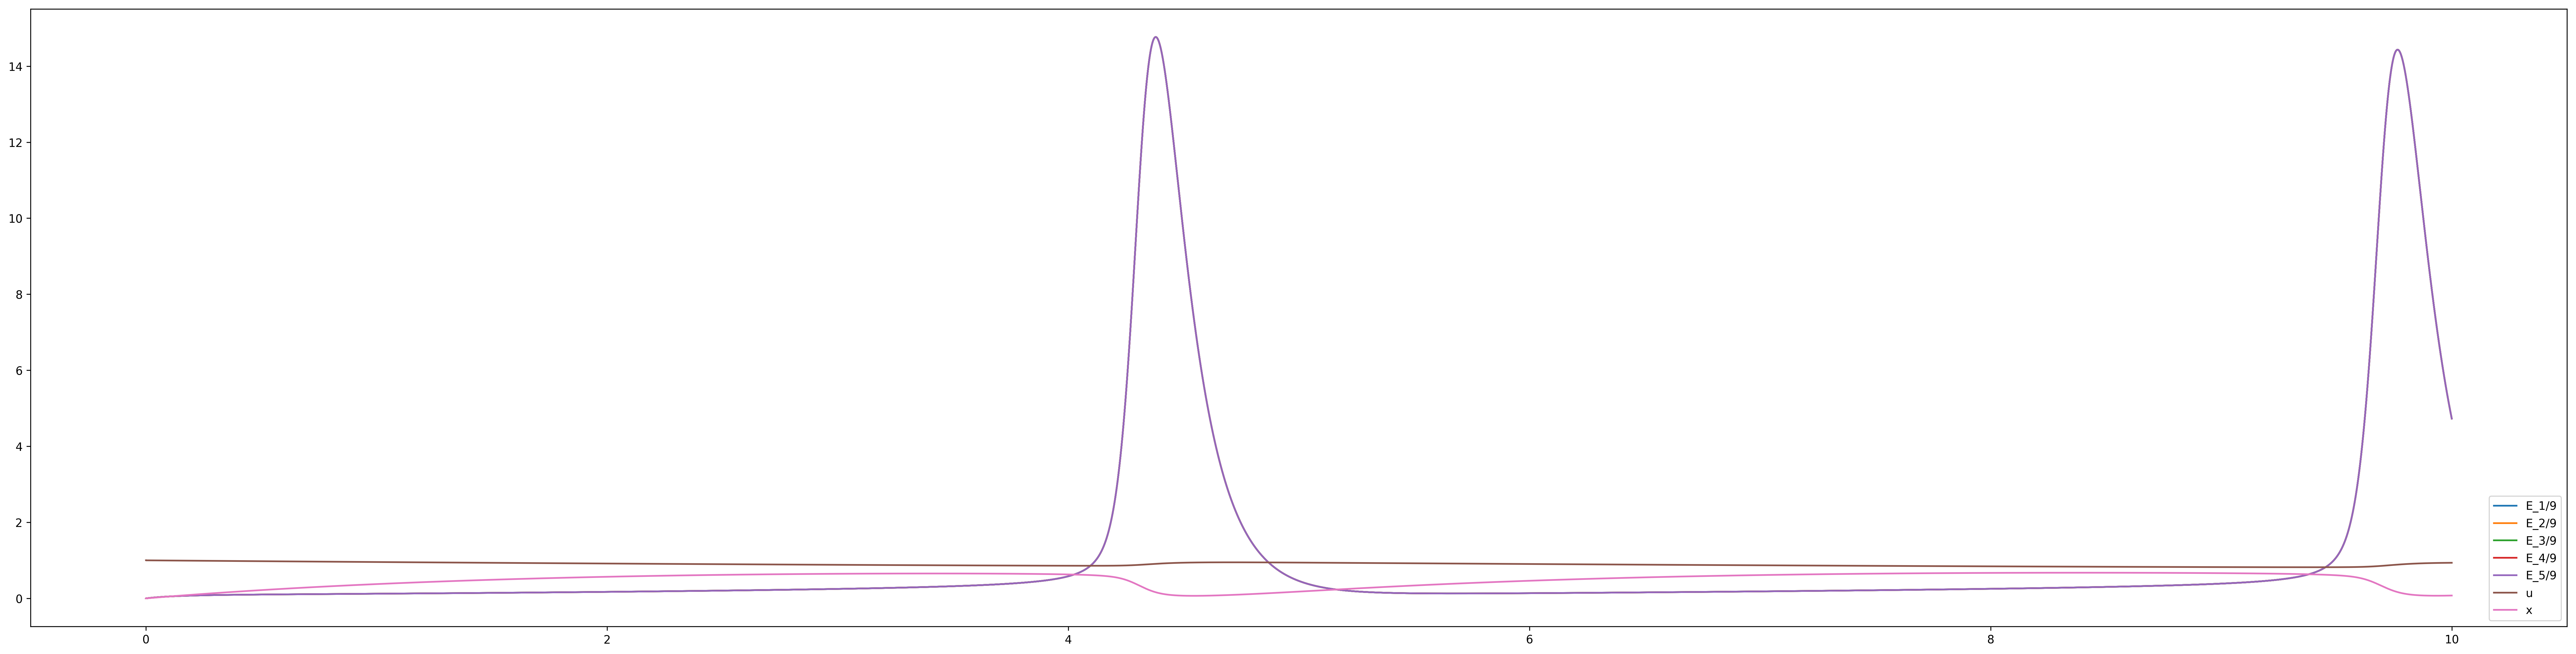

In [16]:
plot_results(300)

In [17]:
# checking ratio inside current : external current
for i in range(int(T) - 1):
    time[i+1] = i * dt
    i = int(2.5*(1/dt))
    for grid_index_i in range(num_grid):
        for grid_index_j in range(num_grid):
            print("E_t{}{}={}".format(grid_index_i+1, grid_index_j+1, E_t[i, grid_index_i+1,grid_index_j+1]))
            print("inside current {} : external current {}".format(J*u_t[i,grid_index_i+1,grid_index_j+1]*x_t[i,grid_index_i+1,grid_index_j+1]\
                                *E_t[i,grid_index_i+1,grid_index_j+1]\
                                ,c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[i, grid_index_i+1-1, grid_index_j+1]\
                                + c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[i, grid_index_i+1, grid_index_j+1+1]\
                                + c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[i, grid_index_i+1+1, grid_index_j+1]\
                                + c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[i, grid_index_i+1, grid_index_j+1-1]
                                ))
    key = input("progress")

E_t11=0.20409412449488828
inside current 0.9072372704377275 : external current 0.001530705933711662
E_t12=0.20409412449488828
inside current 0.9072372704377275 : external current 0.002040941244948883
E_t13=0.20409412449488828
inside current 0.9072372704377275 : external current 0.002040941244948883
E_t14=0.20409412449488828
inside current 0.9072372704377275 : external current 0.002040941244948883
E_t15=0.20409412449488828
inside current 0.9072372704377275 : external current 0.002040941244948883
E_t16=0.20409412449488828
inside current 0.9072372704377275 : external current 0.002040941244948883
E_t17=0.20409412449488828
inside current 0.9072372704377275 : external current 0.002040941244948883
E_t18=0.20409412449488828
inside current 0.9072372704377275 : external current 0.002040941244948883
E_t19=0.20409412449488828
inside current 0.9072372704377275 : external current 0.001530705933711662
E_t21=0.20409412449488828
inside current 0.9072372704377275 : external current 0.002040941244948883


KeyboardInterrupt: 

In [123]:
# param
T = 10 * (1/dt)
num_grid = 9
num_side = 4
scale_factor = 100
c = initialize_c_corner_deleted(num_grid, num_side, scale_factor)

# setting parameter
tau = 0.13
# depressing t_d > t_fac 
# facilitating t_d < t_fac    ++++   prefrontal cortex (PFC) facilitating excitatory connection
t_d = 2
t_fac = 15

t_th = 0.1
thre_effi = 0.02

U = 0.3
E_0_default = -2.3
J = 8
alpha = 0.985

time, E_t, u_t, x_t, z_t = init_dynamical_variable_and_time(num_grid, T, E_ini, u_ini, x_ini, z_ini)
start_simulation(T, num_grid, time, E_t, u_t, x_t, z_t, J, alpha, tau, E_0_default, t_fac, t_d, t_th, thre_effi, U, dt)

starting sinulation
grid size 9*9 simulation time 10sec
parameters are following
tau 0.13 t_fac 15 t_d 2 t_th 0.1 U 0.3
J 8 alpha 0.985 thre_effi 0.02
simulation completed !


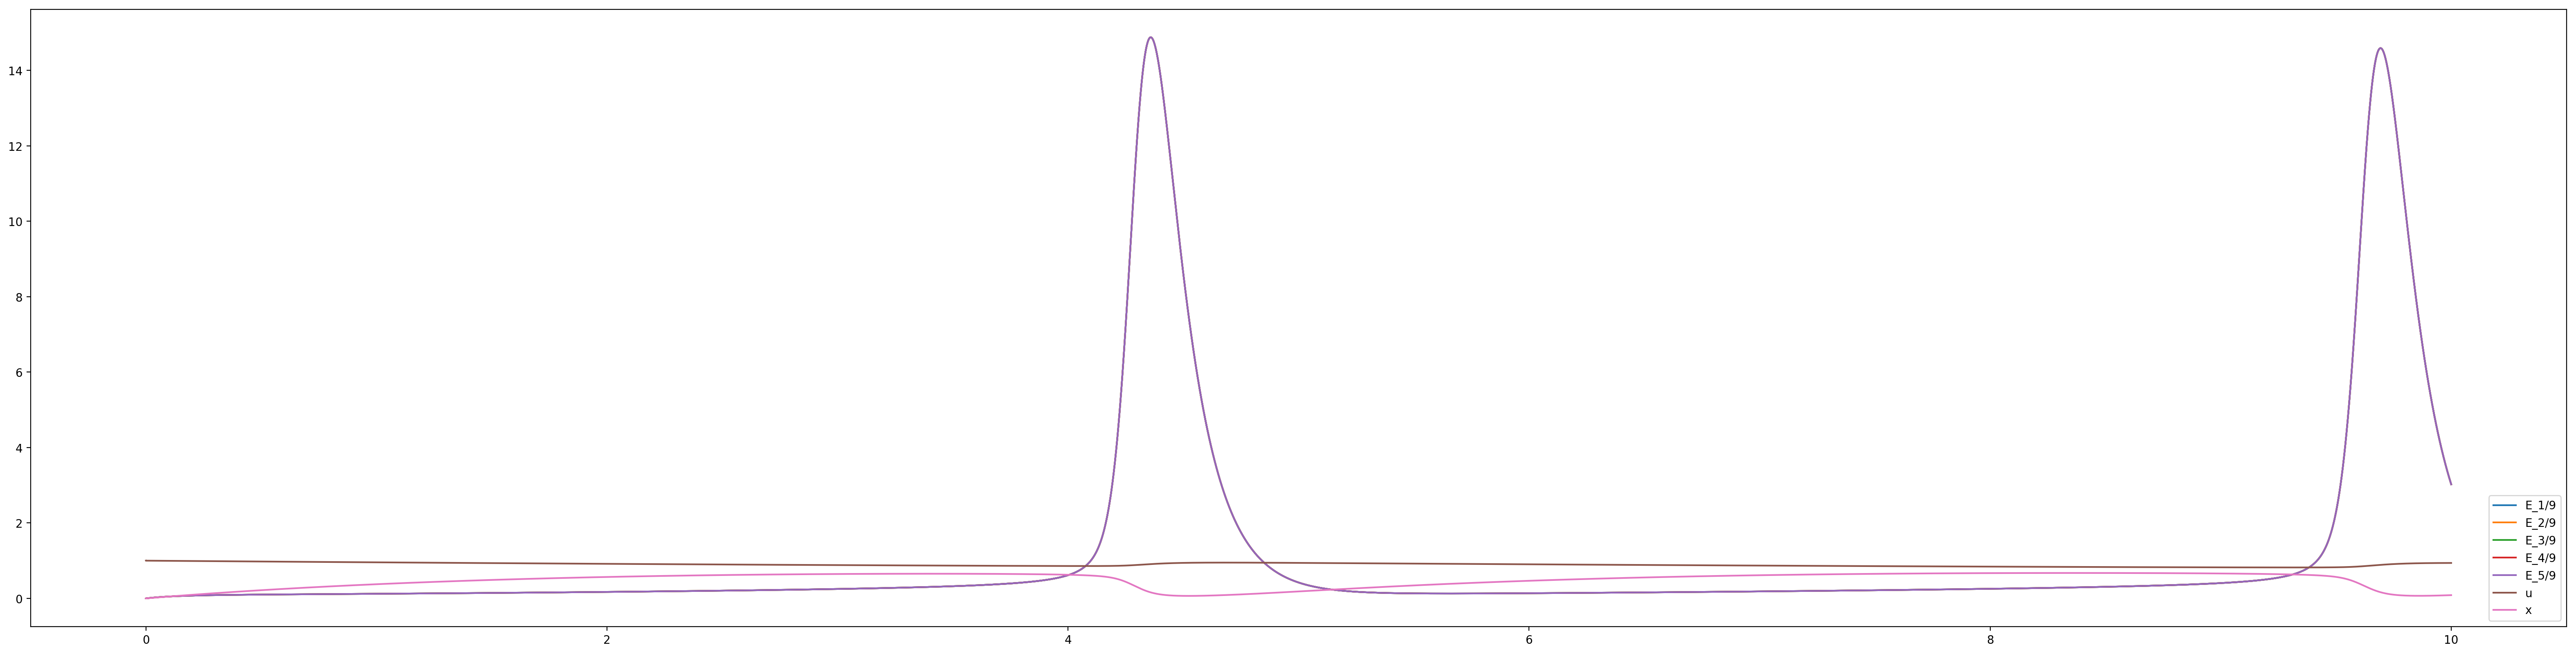

In [124]:
plot_results(200)

In [125]:
# param
T = 100 * (1/dt)
num_grid = 9
num_side = 4
scale_factor = 1
c = initialize_c_corner_deleted(num_grid, num_side, scale_factor)

# setting parameter
tau = 1
# depressing t_d > t_fac 
# facilitating t_d < t_fac    ++++   prefrontal cortex (PFC) facilitating excitatory connection
t_d = 20
t_fac = 150

t_th = 0.1
thre_effi = 0.02

U = 0.3
E_0_default = -6
J = 100
alpha = 1.5

time, E_t, u_t, x_t, z_t = init_dynamical_variable_and_time(num_grid, T, E_ini, u_ini, x_ini, z_ini)
start_simulation(T, num_grid, time, E_t, u_t, x_t, z_t, J, alpha, tau, E_0_default, t_fac, t_d, t_th, thre_effi, U, dt)

starting sinulation
grid size 9*9 simulation time 100sec
parameters are following
tau 1 t_fac 150 t_d 20 t_th 0.1 U 0.3
J 100 alpha 1.5 thre_effi 0.02
simulation completed !


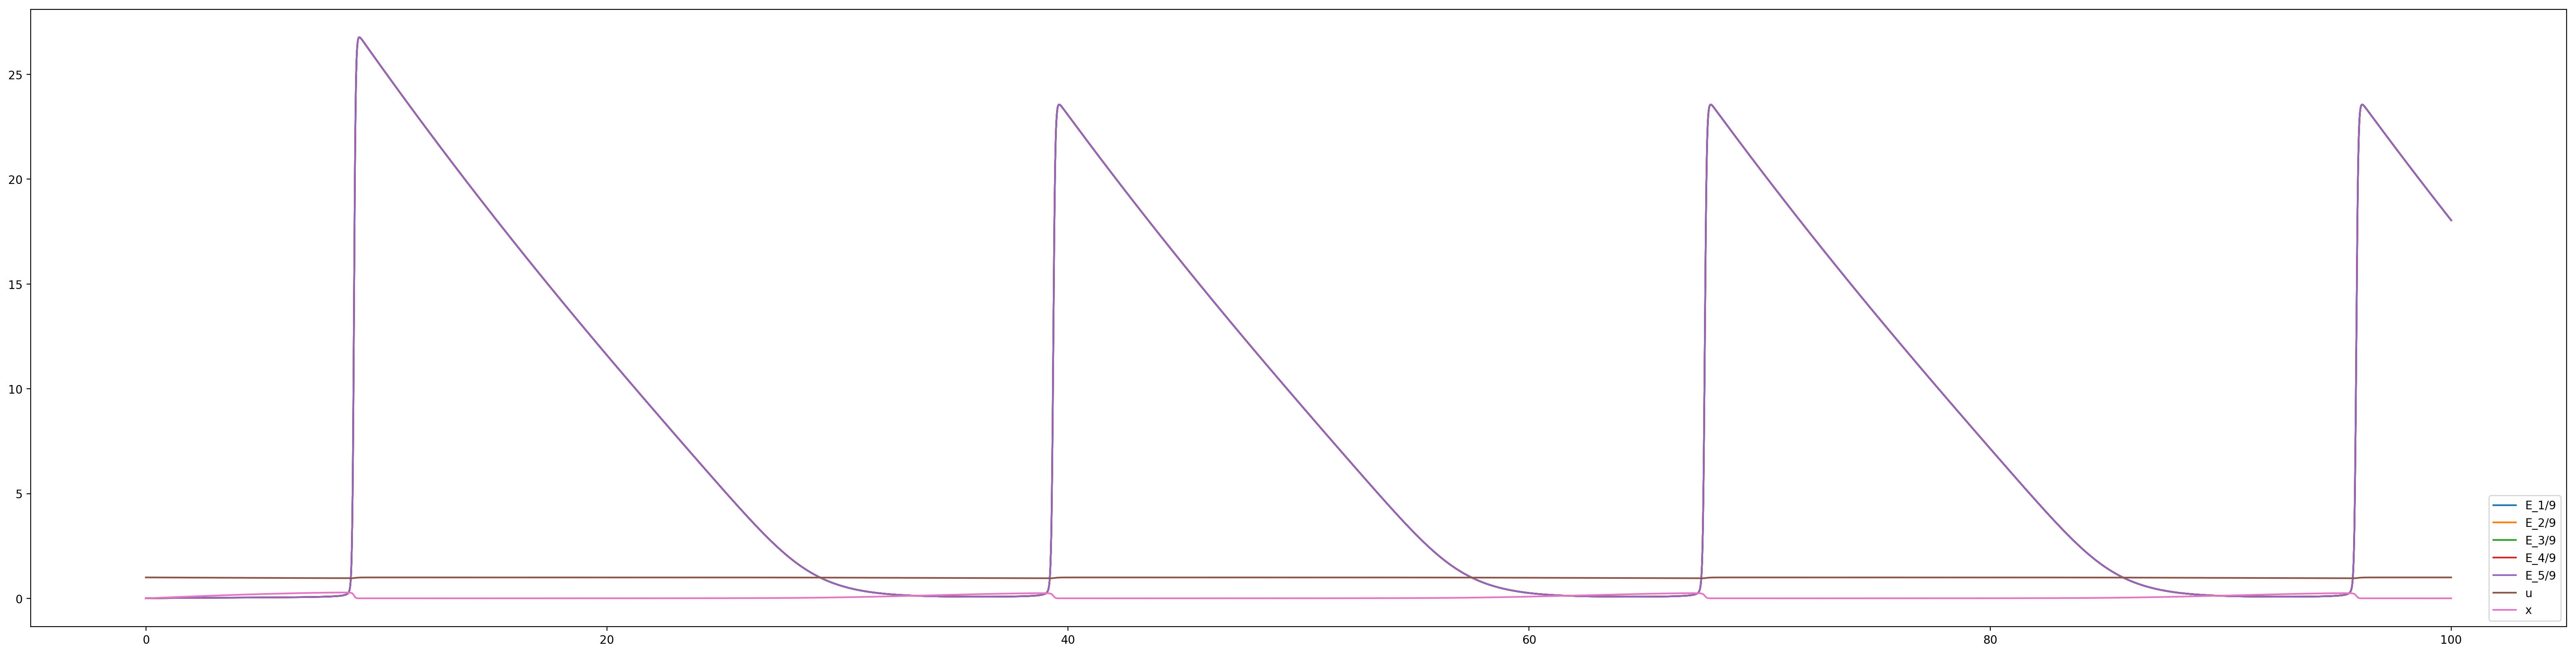

In [126]:
plot_results(200)